# Tutorial: SLAM-seq analysis

In this tutorial, we use *rnalib* for a (simplified) analysis of a simulated [SLAM-seq](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5712218/) timecourse dataset.
In SLAM-seq, cells are subjected to metabolic RNA labelling with the nucleotide analog 4-thiouridine (4sU). Upon RNA extraction and chemical treatment, 4sU is converted into cytosine or cytosine analogs, resulting in 'labeled' reads containing T-to-C conversions. 

For this tutorial, we simulated a small SLAM-seq timecourse (tp=0,5,10,15,20,25; arbitrary units) with 5% T-to-C conversion rate using [splice_sim](https://github.com/popitsch/splice_sim).
We simulated reads for three mouse transcripts (coverage \~100X, read length: 100bp) and configured *splice_sim* to adjust the ratio of labelled vs unlabelled reads over time following a simple exponential decay model for three different decay rates (fast, medium, slow; one transcript each). Thus, at timepoint 0, the reads are nearly fully labeled (i.e, most reads contain at least 1 T/C conversion). Over time, the fraction of labeles reads decreases following the decay model FCR~e^(t × -k), where FCR is the fraction of converted reads and k is the decay rate constant (fast/k=0.15, moderate/k=0.1, slow/k=0.05). Simulated reads were mapped to the mouse genome with [STAR](https://github.com/alexdobin/STAR) and we sliced the BAM files to contain only reads overlapping the three simulated transcripts.

The goal of this tutorial is now to estimate **decay half-lifes** from these data.
Briefly, we proceed as following:

* we describe (partially with code) how the data used in this tutorial was created
* we annotate reads in the BAM files with the number of T-to-C conversions using the *rnalib* `tag_tc()` method.
  This method uses the `ReadIterator`'s ability to report mismatches to the reference sequence
* we load a filtered mouse transcriptome containing GENCODE annotations for the three simulated transcripts
* we annotate these transcripts with the number of overlapping reads and the number of overlapping T-to-C containing reads by filtering the BAM tags created by `tag_tc()`
* we qc, normalise and plot the data
* we fit a simple exponential decay model to the data and calculate half-lives
* Finally, we sketch how to do such an analysis with paired-end sequencing data and how to extract a sequencing error profile from overlapping mate sections


## Requirements
Before executing this notebook, you need to install all required *rnalib* requirements as well as optional libraries needed by this notebook.
It is recommended to do this in a [Python virtual environment](https://rnalib.readthedocs.io/en/latest/readme.html#installation).

This notebook as well as *rnalib*'s testing suite use various **test resources** (genomics data files and indexing structures) that can either be downloaded from the Github repository or 
created by running the *rnalib* `rnalib_create_testdata` script. Please refer to [the rnalib documentation](https://rnalib.readthedocs.io/en/latest/readme.html#test-data) for detailed instructions.
There are two separate test resource sets:

* *test_resources*: small test datasets that are used by *rnalib*'s test suite
* *large_test_resources*: larger test files that are needed to demonstrate *rnalib* under realistic conditions. 

*Rnalib* knows about the location of the test data via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by 'monkeypatching' (rna.__RNALIB_TESTDATA__ = ...) as shown below. Once this is done, test data resources can be accessed via `rna.get_resource(<resource_id>)`. *Rnalib* will recreate these resources only if they are not found in the configured output folder.

In [1]:
# install additional requirements for this notebook
#%pip install rnalib as rna
#%pip install sortedcontainers
#%pip install biopython
#%pip install igv_notebook
#%pip install scipy

In [1]:
# import required libaries 
import os, pathlib, platform, logging, sys, tempfile, pytest, dataclasses, random, pprint, time
from collections import Counter, defaultdict
from tqdm.auto import tqdm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sortedcontainers import SortedSet
import numpy as np
import pandas as pd
import pysam
import pybedtools 
import bioframe
import biotite.sequence as seq
import scipy
from Bio.Align import PairwiseAligner
logging.basicConfig(stream=sys.stderr, level=logging.INFO) # set log level

# IGV support
import igv_notebook
igv_notebook.init()

# load rnalib
import rnalib as rna
from rnalib import gi, GI, SEP, display_textarea
display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")

# ensure test data
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/" # monkeypatch test data dir
rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, (rna.testdata.test_resources,rna.testdata.large_test_resources)) # requires additional tools installed
display(f"Testdata in {rna.__RNALIB_TESTDATA__}")
display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/Users/niko/.virtualenvs/rnalib/lib/python3.12/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.3, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


'Running rnalib 0.0.4 on python 3.12.1'

Creating testdata:   0%|          | 0/50 [00:00<?, ?it/s]

Creating testdata:   0%|          | 0/11 [00:00<?, ?it/s]

INFO:root:========= All done with 0 errors  ==========


'Testdata in rnalib_testdata/'

## Data preparation
We first selected three transcripts that were simulated in this dataset with different decay rates (slow, moderate, high).
We simulated data for the shown timepoints (0, 5, 10, 15, 20, 25; arbitrary units).

In [2]:
sim_tx = {
    "ENSMUST00000182580.7": "slow",     # Snhg6
    "ENSMUST00000188641.6": "moderate", # Eloc
    "ENSMUST00000027303.13": "fast"     # Imp4
}
tps = [0, 5, 10, 15, 20, 25]

If you successfully built the test datasets in the section at the top then you can access the respective GFF3 annotation file via rna.get_resource("slamseq_example_gff").
So, we can now instantiate a mini transcriptome from the created GFF3 file:

In [3]:
# load our small transcriptome containing 3 tx only
t = rna.Transcriptome(annotation_gff=rna.get_resource("slamseq_example_gff"),
                      annotation_flavour="gencode")
t

Building transcriptome (1 chromosomes)
:   0%|          | 0/1 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/3 [00:00<?, ?it/s]

Transcriptome with 3 genes and 3 tx

The BAM files for this example were created by slicing the respective gene regions +/- 1000 bp from the STAR mapped full BAMs using samtools.
The BAM files can be access via `rna.get_resource("slamseq_example_tp{tp}")` for all simulate timepoints (0,5,10,15,20,25).
Here we show what genomic regions are included in the BAMs:

In [4]:
for g in t.genes:
    display(f"Sliced region for {g.gene_name}: {g.get_extended(1000)}")

'Sliced region for Snhg6: 1:9940959-9945118 (-)'

'Sliced region for Eloc: 1:16640725-16658042 (-)'

'Sliced region for Imp4: 1:34438851-34450356 (+)'

Finally, we create an output directory for holding the created files. You can delete this directory after you are done with this tutorial (size is \~3MB).

In [5]:
out_dir = pathlib.Path(rna.__RNALIB_TESTDATA__) / 'slamseq_example' # we will write the created resources to this dir
assert not os.path.isdir(out_dir), f"Output dir {out_dir} exists. Delete it before rerunning the notebook"
os.mkdir(out_dir)

AssertionError: Output dir rnalib_testdata/slamseq_example exists. Delete it before rerunning the notebook

## Annotate T-to-C reads
Now, we first annotate reads with T/C conversions in the alignments.
We use the *rnalib* `tag_tc()` method for this: 

The `tag_tc` method reads a BAM file (that must contain MD tags) and annotates reads by found T/C (or A/G on reverse strand) conversions.
It adds respective BAM tags to the reads and outputs an annotated BAM file for further processing. 
It also creates a pandas dataframe containing read counts stratified by chromosome, number of convertible positions and number of converted 
positions and writes it to a respective TSV file to the output directory if configured.
Finally, the method returns
* A pandas dataframe containing read counts
* The filename of the written (annotated) BAM file that contains 3 additional tags:
    * `xt`: number of convertible positions (Number of T's or A's, depending on read strand)
    * `xc`: number of converted positions (T>C or A>G)
    * `YC`: read color: reads with at least one converted positions are colored red, with an rgb value calculated from the 
      fraction of converted positions
* The path of the (bgzipped and indexed) TSV file (unless write_density_histogram=False)

The method can also filter known SNP positions (passed via a VCF file), normalize read counts by NH tag and more, see docs for details.
Note that you can call this tool also from the commandline via `rnalib tag_tc -h`.

In [6]:
rna.display_help(rna.tag_tc)

<IPython.core.display.Javascript object>

In [7]:
# run tag_tc for all datasets. This results in BAM files that contain tc/tt/YC tags as well as some stats
profiles=list()
tc_bams=dict()
for tp in tps:
    ds = f"slamseq_example_tp{tp}" # this the prefix of how the BAM files are named
    out_prefix = str(pathlib.Path(out_dir) / ds) # the output path
    profile, tc_bam, tc_stats = rna.tag_tc(rna.get_resource(ds), out_prefix=out_prefix) # this method iterates the reads, counts T-to-C conversions and write xc/xt/YC BAM tags
    tc_bams[ds] = tc_bam # keep a map of dataset to tc-annotated-BAM
    profile['tp'] = tp # add timepoint to mismatch profile data
    profiles.append(profile) # combine for all datasets (BAMs)
    #display(profile, tc_bam, tc_stats)
profile = pd.concat(profiles) 

  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/8134 [00:00<?, ?it/s]

  0%|          | 0/8134 [00:00<?, ?it/s]

  0%|          | 0/8136 [00:00<?, ?it/s]

  0%|          | 0/8136 [00:00<?, ?it/s]

  0%|          | 0/8136 [00:00<?, ?it/s]

As a first QC check we can inspect the created BAM files and visualize with IGV. NOTE that the `tag_tc()` method also added YC tags for reads that 
contain at least one T-to-C conversion and we use this tag for coloring the reads below. 
NOTE: if the BAMs are not shown, please check whether the respective path is correct.

In [8]:
igv_notebook.Browser({ "genome": "mm10", 
                       "tracks": [{ "name": ds, 
                                    "path": p,
                                    "indexPath": p+".bai", 
                                    "format": "bam",
                                    "type": "alignment", 
                                    "displayMode": "SQUISHED",
                                    "colorBy": "tag", 
                                    "colorByTag": "YC" } for ds,p in tc_bams.items()]}).search(t.genes[0].gene_name) # navigate to the first genes

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In these (simulated) alignments, you can observe that:

* the number of converted reads decreases over time
* not all reads at timepoint zero are labeled.

The reasons for the latter are discussed below. 

As a second QC check, we can now calculate the fraction of T-to-C conversions per dataset and plot. 
We do this separately for both possible reference allele (for plus-strand transcripts we will observe T-to-C conversions in the strand-specific reads, for minus transcripts we will see A-to-G conversions).

convertible  converted   frac_tc
tp ref                                  
0  A          74255       3602  0.048509
   T         165126       7953  0.048163
5  A          74457       2572  0.034543
   T         165285       3993  0.024158
10 A          74500       1691  0.022698

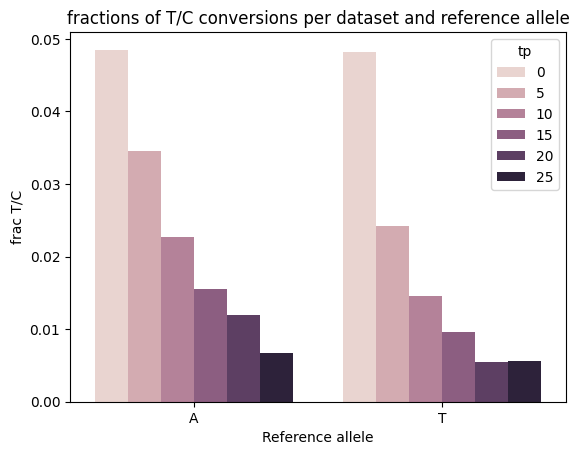

In [9]:
# plot T/C conversion statistics
df = profile.copy()
 # The mismatch profile counts the number of (convertible/converted) pairs, so we must multiply with this count befor summing per timepoint and reference allele
df['converted'] = df['converted'] * df['count']
df['convertible'] = df['convertible'] * df['count']
# sum pre timepoint/reference allele
df = df.groupby(['tp', 'ref'])[['convertible', 'converted']].sum()
# calculate fraction of T-to-C reads
df['frac_tc'] = df['converted']/ df['convertible']
# show some data
display(df.head())
# plot
ax = sns.barplot(data=df, x="ref", y="frac_tc", hue="tp")
_ = ax.set(xlabel='Reference allele', ylabel='frac T/C', title='fractions of T/C conversions per dataset and reference allele')

We can clearly see the 'decay' over time as expected but note that this now for all (3) transcripts combined and does not separate between exonic and intronic data.

## Count T-to-C reads

### Custom count function
We can now annotate all transcripts with the number of overlapping T-to-C reads, using the *rnalib* `annotate()` function. 

As annotation method we pass a simple `count_tc_reads()` method that takes a list of datasets as parameters and then returns an annotation function `count()` that will be called by 
the respective AnnotationIterator. This function implements the actual read counting. By 'encapsulating' it in the `count_tc_reads()` function, it has access to the dataset names 
that we also use as 'labels' for the `annotate()` method. 

In a summary, the shown `count()` method:
* is called for each transcript in the transcriptome
* has access to the anno dict of this exon
* has access to all reads that overlap this trasncript, grouped by dataset
* knows about the dataset labels via its call context (the count_tc_reads() method)

It then simply counts the number of reads and the number of reads that have a xc tag > 0 (i.e., reads stemming from "new" RNA containing at least one T-to-C conversion) and stores them in the anno dict.
Note, that this is a simplified approach of the actual process as there are of course also reads stemming from "new" RNA that do not contain any T-to-C conversion by chance. We discuss this in more detail below...

In [10]:
def count_tc_reads(datasets):
    """ creates a count function with access to the dataset names """
    def count(item):
        tx = item.location
        print(f"Counting transcript {tx.feature_id}") 
        anno = item.data.anno # this is the dict that annotates this transcript. We can read from there but also add new annotations
        for ds in datasets: # note that we annotate for all datasets (BAM files) in parallel.
            if ds not in anno:
                anno[ds] = Counter() # create a counter object if annotation does not exist.
            reads = [r.data for r in getattr(item.data, ds)] # get all reads.
            # NOTE: here we could, e.g., filter reads that do not overlap sufficiently with the exons of this transcript using the aligns_to() method, etc.
            anno[ds]['all'] = len(reads) # count all reads            
            anno[ds]['tc'] = len([r for r in reads if r.get_tag('xc', 0)>0]) # count reads with xc (number of T-to-C conversions) > 0
    return count # return the count method so it can be used as callback by annotate()
    
t.annotate(anno_its=[rna.it(bam_file) for bam_file in tc_bams.values()], # list of bam iterators
           fun_anno=count_tc_reads(tc_bams.keys()), # create the callback method, passing the dataset names
           labels=list(tc_bams.keys()), # use the same dataset names as annotation labels so we can distinguish between the read count groups
           feature_types='transcript')  # annotate only transcript fetaures.

  0%|          | 0/1 [00:00<?, ?it/s]

Counting transcript ENSMUST00000182580.7
Counting transcript ENSMUST00000188641.6
Counting transcript ENSMUST00000027303.13


### featureCounts
Note that while this counting approach is sufficient for this simplified example, it is neither performant nor accurate if you are working with a real dataset 
that would also contain intronic reads that overlap with a transcript annotation but should not be counted, etc. 
You should therefore use specialised counting tools (e.g., featureCounts) or implement more advanced counting functions for real data (you could, e.g., consider using *rnalib*'s `aligns_to()` method to improve the counting functions).

Here, we sketch a possible way of how you could use [featureCounts](https://doi.org/10.1093/bioinformatics/btt656) for this task. 
First, you need to create filtered BAM files that contain reads with at least one T-to-C conversion. 
You can do this by applying *rnalib*'s `filter_tc` method. This method reads a `tag_tc()` annotated BAM file and filters based on a configured minimum 
number of conversions. Filtered BAMs can then be used for downstream analyses, e.g., for counting via [featureCounts](https://doi.org/10.1093/bioinformatics/btt656).

Note that you can call this tool also from the commandline via `rnalib filter_tc -h`. 

In [16]:
rna.display_help(rna.filter_tc)

<IPython.core.display.Javascript object>

So, here we create filtered BAM files and display one example in IGV. 

In [11]:
filtered_bams = { ds: rna.filter_tc(tc_bam, f"{pathlib.Path(out_dir)/pathlib.Path(tc_bam).stem}_tc-only.bam", min_tc=1) # include only reads with at least one T-to-C conversion
        for ds, tc_bam in tc_bams.items() }

# show one example (tp 25)
tc_bam, filtered_bam = list(tc_bams.values())[-1], list(filtered_bams.values())[-1]
igv_notebook.Browser({ "genome": "mm10", 
                       "tracks": [{ "name": ds, 
                                    "path": p,
                                    "indexPath": p+".bai", 
                                    "format": "bam",
                                    "type": "alignment", 
                                    "displayMode": "SQUISHED",
                                    "colorBy": "tag", 
                                    "colorByTag": "YC" } for ds,p in {'tc_bam': tc_bam, 'filtered_bam': filtered_bam}.items()]}).search(t.genes[0].gene_name) # navigate to the first genes

  0%|          | 0/8130 [00:00<?, ?it/s]

  0%|          | 0/8134 [00:00<?, ?it/s]

  0%|          | 0/8134 [00:00<?, ?it/s]

  0%|          | 0/8136 [00:00<?, ?it/s]

  0%|          | 0/8136 [00:00<?, ?it/s]

  0%|          | 0/8136 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The filtered BAM file contains only "red" reads, as expected.

You could now run the following commands :

`featureCounts -s 1 -t exon --largestOverlap -g ID -a slamseq_example_mm10.gff3.gz -o slamseq_example_featureCounts_all_reads.txt *+tc.bam` 

and

`featureCounts -s 1 -t exon --largestOverlap -g ID -a slamseq_example_mm10.gff3.gz -o slamseq_example_featureCounts_tc_reads.txt *+tc_tc-only.bam`

to get strand-specific read counts per exon including *all* reads and *T-to-C reads* respectively. 
We have included the respective output files in our test resources, so you can directly access them here:

In [18]:
display(pd.read_csv(rna.get_resource("slamseq_example_featureCounts_all_reads"), sep='\t', comment='#').head(3))
display(pd.read_csv(rna.get_resource("slamseq_example_featureCounts_tc_reads"), sep='\t', comment='#').head(3))

Geneid  Chr    Start      End Strand  Length  \
0  ENSMUST00000182580.7_exon_0    1  9941959  9942155      -     197   
1  ENSMUST00000182580.7_exon_1    1  9942323  9942391      -      69   
2  ENSMUST00000182580.7_exon_2    1  9942610  9942717      -     108   

   slamseq_example_tp0+tc.bam  slamseq_example_tp10+tc.bam  \
0                         196                          194   
1                         167                          173   
2                         211                          212   

   slamseq_example_tp15+tc.bam  slamseq_example_tp20+tc.bam  \
0                          195                          196   
1                          172                          170   
2                          214                          215   

   slamseq_example_tp25+tc.bam  slamseq_example_tp5+tc.bam  
0                          196                         195  
1                          173                         171  
2                          213                         211

Geneid  Chr    Start      End Strand  Length  \
0  ENSMUST00000182580.7_exon_0    1  9941959  9942155      -     197   
1  ENSMUST00000182580.7_exon_1    1  9942323  9942391      -      69   
2  ENSMUST00000182580.7_exon_2    1  9942610  9942717      -     108   

   slamseq_example_tp0+tc_tc-only.bam  slamseq_example_tp10+tc_tc-only.bam  \
0                                 146                                  107   
1                                 118                                  102   
2                                 149                                  117   

   slamseq_example_tp15+tc_tc-only.bam  slamseq_example_tp20+tc_tc-only.bam  \
0                                   81                                   66   
1                                   66                                   54   
2                                   79                                   65   

   slamseq_example_tp25+tc_tc-only.bam  slamseq_example_tp5+tc_tc-only.bam  
0                                   54                                 126  
1                                   50                                 105  
2                                   52                                 122

Now we annotate all exons in our transcriptome with these counts...

In [12]:
exon_anno = { ex.feature_id: anno for ex,anno in t.iterator(feature_types='exon') }
# map columns to dataset names
ds = [s.split('+')[0] for s in pd.read_csv(rna.get_resource("slamseq_example_featureCounts_all_reads"), sep='\t', comment='#', index_col='Geneid').columns if s.startswith('slamseq')]
for dat in pd.read_csv(rna.get_resource("slamseq_example_featureCounts_all_reads"), sep='\t', comment='#', index_col='Geneid').itertuples():
    exon_id=dat[0]
    for k,v in zip(ds, dat[6:]):
        if k not in exon_anno[exon_id]:
            exon_anno[exon_id][k]=Counter()
        exon_anno[exon_id][k]['all'] = v
for dat in pd.read_csv(rna.get_resource("slamseq_example_featureCounts_tc_reads"), sep='\t', comment='#', index_col='Geneid').itertuples():
    exon_id=dat[0]
    for k,v in zip(ds, dat[6:]):
        exon_anno[exon_id][k]['tc'] = v

... and sum the featureCounts data per transcript:

In [13]:
for tx in t.transcripts:
    for ds in tc_bams.keys():
        t[tx][ds]['all_fc'] = sum([t[ex][ds]['all'] for ex in tx.exon])
        t[tx][ds]['tc_fc'] = sum([t[ex][ds]['tc'] for ex in tx.exon])

As a quick QC check, we compare the transcript-associated counts from our custom count method and the exon-associated counts from featureCounts.
Below, we plot the data and confirm that the counts are very similar.

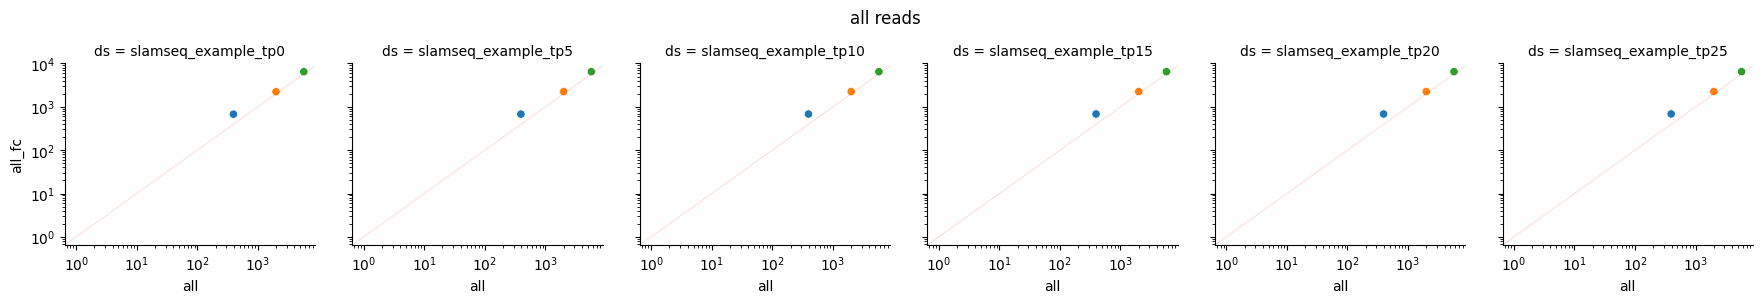

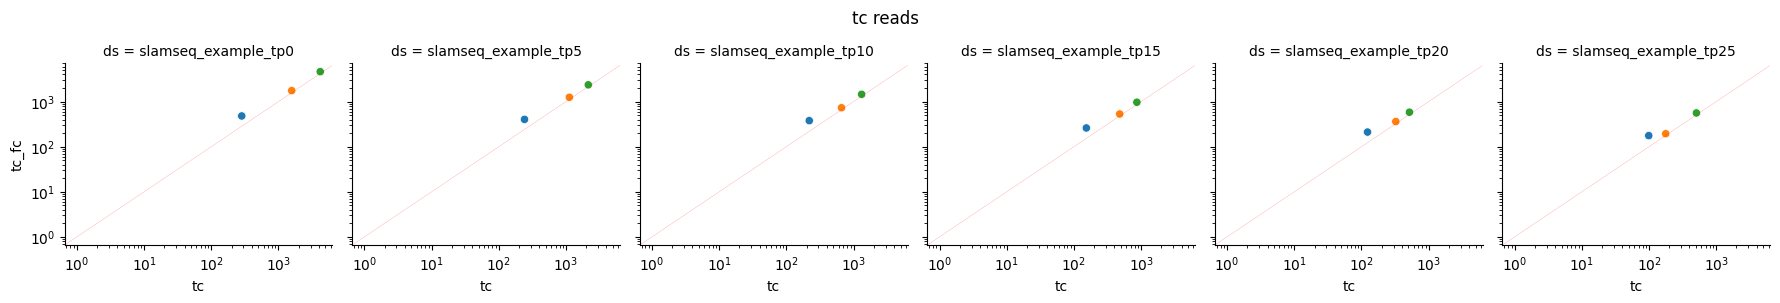

In [14]:
# convert to dataframe
df = df.from_records([(tx.feature_id, ds, t[tx][ds]['all'], t[tx][ds]['tc'], t[tx][ds]['all_fc'], t[tx][ds]['tc_fc'], ) 
                 for ds in tc_bams.keys() for tx in t.transcripts]).rename(columns={0: 'tx', 1: 'ds', 2: 'all', 3: 'tc', 4:'all_fc', 5:'tc_fc'})

# plot the data
g = sns.FacetGrid(df, col="ds")
g.map(sns.scatterplot, "all", "all_fc", "tx").set(yscale = 'log', xscale = 'log')
for ax in g.axes[0]:
    ax.axline((0, 0), (1, 1), linewidth=0.1, color='r')
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle('all reads')
g = sns.FacetGrid(df, col="ds")
g.map(sns.scatterplot, "tc", "tc_fc", "tx").set(yscale = 'log', xscale = 'log')
for ax in g.axes[0]:
    ax.axline((0, 0), (1, 1), linewidth=0.1, color='r')
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle('tc reads')

In this tutorial, however, we now continue with the counts we calculated with our custom count() function above.

As a QC measure, we can calculate the counted coverage per transcript by calculating (counted reads * simulated readlen)/(length of spliced transcript). 
The simulated data used a readlen of 100bp and simulated each transcript with a coverage of ~100X and we can see that our calculated coverage is pretty close to this:

In [15]:
[(tx.parent.gene_name, t.anno[tx]['slamseq_example_tp0']['all']*100 / sum([len(ex) for ex in tx.exon]), ) for tx in t.transcripts]

[('Snhg6', 83.50951374207189),
 ('Eloc', 99.10625620655412),
 ('Imp4', 98.33790267306374)]

Now, we can calculate the fraction of reads with at least one T-to-C conversion (frac_tc):

In [16]:
df['frac_tc'] = df['tc']/df['all']
df['decay_rate'] = [sim_tx[tid] for tid in df.tx] # add decay rate labels for plotting
df['tp'] = pd.to_numeric(df['ds'].str[len('slamseq_example_tp'):]) # add nurmeric timepoint for plotting
df.head()

tx                   ds   all    tc  all_fc  tc_fc  \
0   ENSMUST00000182580.7  slamseq_example_tp0   395   284     676    480   
1   ENSMUST00000188641.6  slamseq_example_tp0  1996  1573    2231   1751   
2  ENSMUST00000027303.13  slamseq_example_tp0  5739  4183    6451   4612   
3   ENSMUST00000182580.7  slamseq_example_tp5   394   241     678    403   
4   ENSMUST00000188641.6  slamseq_example_tp5  2002  1121    2246   1247   

    frac_tc decay_rate  tp  
0  0.718987       slow   0  
1  0.788076   moderate   0  
2  0.728873       fast   0  
3  0.611675       slow   5  
4  0.559940   moderate   5

We now normalize the frac_tc (fraction of T-to-C reads) measure to the maximum value per transcript (which is typically the first timepoint).

In [17]:
df['max_ftc'] = df.groupby(['tx'])['frac_tc'].transform('max')
df['frac_tc_norm'] = df['frac_tc']/df['max_ftc']
df.head()

tx                   ds   all    tc  all_fc  tc_fc  \
0   ENSMUST00000182580.7  slamseq_example_tp0   395   284     676    480   
1   ENSMUST00000188641.6  slamseq_example_tp0  1996  1573    2231   1751   
2  ENSMUST00000027303.13  slamseq_example_tp0  5739  4183    6451   4612   
3   ENSMUST00000182580.7  slamseq_example_tp5   394   241     678    403   
4   ENSMUST00000188641.6  slamseq_example_tp5  2002  1121    2246   1247   

    frac_tc decay_rate  tp   max_ftc  frac_tc_norm  
0  0.718987       slow   0  0.718987      1.000000  
1  0.788076   moderate   0  0.788076      1.000000  
2  0.728873       fast   0  0.728873      1.000000  
3  0.611675       slow   5  0.718987      0.850745  
4  0.559940   moderate   5  0.788076      0.710515

Now we can plot normalised fraction T-to-C over time per transcript. We use the decay rate labels we have defined above for this plot:

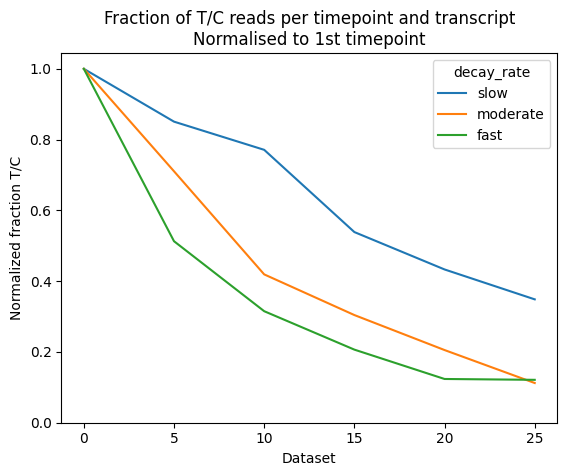

In [18]:
ax = sns.lineplot(data=df, x="tp", y="frac_tc_norm", hue="decay_rate")
_ = ax.set(xlabel='Dataset', ylabel='Normalized fraction T/C', title='Fraction of T/C reads per timepoint and transcript\nNormalised to 1st timepoint')
_ = ax.set_ylim(bottom=0)

We can see that T-to-C fraction of the fast decaying transcript is dropping fastest, the medium decay curve is in the middle and the slowly decaying one is on top.
So the measures we derived from the data match the expectation (respectively the configuration of the simulation process).

## Fit data to decay function

Now, we can fit a simple exponential decay model to these T-to-C fraction values and show the estimated k:

In [19]:
def fit_nexp(grp):
    x,y = grp.tp, grp.frac_tc_norm
    popt, pcov = scipy.optimize.curve_fit(lambda t,k: np.exp(t*-k),  x,  y)
    return pd.Series(popt, index=['k'])

fit_params = df.groupby(['tx', 'decay_rate']).apply(fit_nexp, include_groups=False).reset_index()
display(fit_params)

tx decay_rate         k
0  ENSMUST00000027303.13       fast  0.112599
1   ENSMUST00000182580.7       slow  0.038694
2   ENSMUST00000188641.6   moderate  0.080638

Here, we add the real (simulated) k values for comparison and calculate estimated and simulated half-lives (hl = ln(2)/k):

In [20]:
fit_params['k_real'] = [0.15, 0.05, 0.1]
fit_params['hl'] = np.log(2)/fit_params['k']
fit_params['hl_real'] = np.log(2)/fit_params['k_real']
display(fit_params)

tx decay_rate         k  k_real         hl    hl_real
0  ENSMUST00000027303.13       fast  0.112599    0.15   6.155898   4.620981
1   ENSMUST00000182580.7       slow  0.038694    0.05  17.913725  13.862944
2   ENSMUST00000188641.6   moderate  0.080638    0.10   8.595804   6.931472

The estimated k's underestimate the real values (slow=0.05, moderate=0.1, fast=0.15) which in turn results in an overestimation of the respective half-lives. 
This happens because not all reads that were simulated at a given timepoint contain a converted base (a T-to-C conversion) given the low conversion 
probability of 5% per convertible base (it is assumed that number of T-to-C conversions per read follow a binomial distribution with p=0.05 and n=number_convertible_bases). 
This is also the reason why frac_tc does not reach 1.0 at timepoint zero (we then normalized to this timepoint). On the other hand, (simulated) T>C sequencing errors lead to some reads being wrongly counted as "coverted" which is why frac_tc never reaches zero.

Despite these problems that can only be addressed by more complex approaches, the predicted half-lifes are close to the real values and their relative order is correct. We can now plot 'measured' and predicted frac_tc values:

tx  tp  frac_tc_norm decay_rate         k  frac_tc_pred
0   ENSMUST00000182580.7   0      1.000000       slow  0.038694      1.000000
1   ENSMUST00000188641.6   0      1.000000   moderate  0.080638      1.000000
2  ENSMUST00000027303.13   0      1.000000       fast  0.112599      1.000000
3   ENSMUST00000182580.7   5      0.850745       slow  0.038694      0.824096
4   ENSMUST00000188641.6   5      0.710515   moderate  0.080638      0.668186

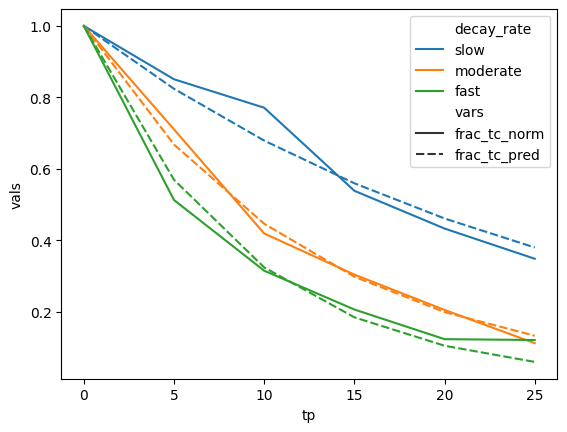

In [21]:
dat = df[['tx', 'tp', 'frac_tc_norm', 'decay_rate']].set_index(['tx']).join(fit_params[['tx','k']].set_index(['tx'])).reset_index() # add k to the dataframe
dat['frac_tc_pred'] = np.exp(dat['tp']*-dat['k']) # calculate predicted frac_tc values
sns.lineplot(data = dat.melt(['tx', 'tp', 'k', 'decay_rate'], var_name='vars', value_name='vals'),
                 x="tp", y="vals", hue="decay_rate", style="vars") # plot
display(dat.head()) # show some data

## Paired end data example
If you have paired-end sequencing data, you can use *rnalib*'s `PairedReadIterator` for iterating read pairs and their mismatches as demonstrated below.
In this small example, we analzye two published mouse SLAM-seq samples published by [Erhard et al., 2019](https://pubmed.ncbi.nlm.nih.gov/31292545/):
* [GSM3185046](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3185046) is a bulk-RNAseq NIH-3T3 fibroblasts sample without 4sU addition
* [GSM3185043](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3185043) is a bulk-RNAseq NIH-3T3 fibroblasts sample that was labelled for 2h with 500 µM 4sU addition
* The BAMs were created by preprocessing the reads with fastp and mapping to mm10 with STAR. SNPs were called in the no4sU sample using deepvariantwith an RNA-seq model.
* The BAM files and the VCF file were sliced to contain data for Snhg6, Eloc and Imp4 only.

We then count T-to-C conversions and calculate frac_tc per gene. T-to-C SNPs are filtered.
We also analyse the overlapping parts of the iterated read pairs. Here, the same part of an RNA molecule is sequenced twice and we assume that mismatches between the two mates are sequencing errors. 

### Data preparation

In [22]:
# load our small transcriptome containing 3 tx only
t = rna.Transcriptome(annotation_gff=rna.get_resource("slamseq_example_gff"),
                      annotation_flavour="gencode")
t

Building transcriptome (1 chromosomes)
:   0%|          | 0/1 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/3 [00:00<?, ?it/s]

Transcriptome with 3 genes and 3 tx

Now we define two datasets, one with and one without 4sU...

In [23]:
snp_vcf_file = rna.get_resource("slamseq_example_pe_no4sU_vcf")
datasets = pd.DataFrame.from_records([("no4sU", rna.get_resource("slamseq_example_pe_no4sU_bam")),("4sU", rna.get_resource("slamseq_example_pe_4sU_bam"))], columns=["name", "bam_file"])
datasets

name                                        bam_file
0  no4sU  rnalib_testdata//bam/GSM3185046.pe_example.bam
1    4sU  rnalib_testdata//bam/GSM3185043.pe_example.bam

### Count T-to-C conversions and sequencing errors in read pairs

Now we iterate all read pairs per transcript in both datasets, count T-to-C conversions and sequencing errors and add those counts to the transcriptome.

In [24]:
def get_tc_counts(r1,r2,mm1,mm2,masked_pos, strand, min_base_quality=10, fractional_counts=True):
    """ Counts T-to-C conversions in the passed read pair.
        SNP positions are masked and only base calls with a given minimum quality are considered.
        Read counts are normalised by the number of alignment positions with similar (max) score (NH tag).
        Mismatches between mates in overlapping regions are reported as sequencing errors.
    """
    seq_err=set()
    refc,altc = ('T', 'C') if strand=="+" else ('A','G')
    if r2 is None:
        mate_overlap_len = 0
    else:    
        os, oe = max(r1.reference_start+1, r2.reference_start+1), min(r1.reference_end, r2.reference_end) # mate-overlapping region
        mate_overlap_len = oe-os+1
        if mate_overlap_len>0:
            omm1 = {(off,pos,ref,alt) for off,pos,ref,alt in mm1 if os<=pos<=oe}
            omm2 = {(off,pos,ref,alt) for off,pos,ref,alt in mm2 if os<=pos<=oe}
            shared, m1_only, m2_only = rna.cmp_sets(omm1, omm2)
            seq_err = m1_only | m2_only # list of (off,pos,ref,alt) tuples that are considered as seq errors due to mate mismatch.
            masked_pos |= {pos for off,pos,ref,alt in seq_err} # add seqerrs to the masked positions of this read pair
    # set of (off, pos, alt) tuples
    t_pos = SortedSet( [(off, pos + 1, r1.query_sequence[off]) for (off, pos, ref) in r1.get_aligned_pairs( with_seq=True, matches_only=True ) if (ref.upper() == refc) and (r1.query_qualities[off] >= min_base_quality) and (pos + 1 not in masked_pos) ] )
    if r2 is not None:        
        t_pos |= SortedSet([(off, pos + 1, r2.query_sequence[off]) for (off, pos, ref) in r2.get_aligned_pairs( with_seq=True, matches_only=True ) if (ref.upper() == refc) and (r2.query_qualities[off] >= min_base_quality) and (pos + 1 not in masked_pos) ] )
    tc_pos = {(off, pos1) for off,pos1,alt in t_pos if alt == altc}
    ntt = len(t_pos)
    ntc = len(tc_pos)
    if fractional_counts:
        nh = r1.get_tag("NH") if r1.has_tag("NH") else 1
        ntt /=  nh # TODO: check wheth NH can be different for r1/r2
    return ntt, ntc, [pos1 for (off, pos1, ref) in t_pos], [pos1 for (off, pos1) in tc_pos], seq_err, mate_overlap_len

for tx in t.transcripts: # init one counter per dataset    
    t.anno[tx] = dict()
    for name in datasets.name:
        t.anno[tx][name] = Counter()
    
seq_err_profile= Counter()
for ds in datasets.itertuples():
    print("analysing", ds.name)
    for tx in t.transcripts:
        # get T/C SNPs for this region and store as masked positions
        with rna.it(snp_vcf_file, region=tx) as it:
            masked_pos = set([loc.start for loc, snp in it if (snp.ref, snp.alt) in [('T','C'), ('A','G')]])
        
        with rna.PairedReadIterator(ds.bam_file, region=tx, report_mismatches=True, filter_pcr_duplicates=False) as it:
            for loc, (r1,r2,mm1,mm2) in it:
                pair_is_reverse = (r1.is_reverse) if r1 is not None else (not r2.is_reverse)
                pair_is_reverse = not pair_is_reverse # we need to reverse the strand as the antisense strand was sequenced (so pair strand is reversed)
                pair_strand = "-" if pair_is_reverse else "+"
                
                # skip pairs mapping to wrong strand
                if tx.strand != pair_strand:
                    continue 

                # check whether pair aligns to transcript exons                 
                read_blocks = [rna.gi(r1.reference_name,a+1,b) for a,b in r1.get_blocks()]
                if r2 is not None:
                    read_blocks += [rna.gi(r2.reference_name,a+1,b) for a,b in r2.get_blocks()]
                pair_aligns = rna.aligns_to(tx.exon, read_blocks) 
    
                if pair_aligns:
                    # get TC counts
                    ntt, ntc, t_pos, tc_pos, seq_err, mate_overlap_len = get_tc_counts(r1,r2,mm1,mm2,masked_pos, tx.strand)
                    # update counts
                    t.anno[tx][ds.name]['pair_count']+=1
                    t.anno[tx][ds.name]['ntt']+=ntt
                    t.anno[tx][ds.name]['ntc']+=ntc
                    t.anno[tx][ds.name]['n_seqerr']+=len(seq_err)
                    if seq_err is not None:
                        for (off, pos,ref,alt) in seq_err:                                
                            seq_err_profile[ds.name, ref,alt,tx.strand]+=1
seq_err_profile=pd.DataFrame.from_records([(ds,f"{ref}>{alt}",strand,c) for (ds,ref,alt,strand),c in seq_err_profile.items()], columns=['name', 'se','strand','count'])
seq_err_profile.head()

analysing no4sU
analysing 4sU


name   se strand  count
0  no4sU  A>G      -     39
1  no4sU  T>A      -    110
2  no4sU  A>T      -     92
3  no4sU  T>G      -     18
4  no4sU  C>A      -    242

### Plot the results

Now, we first plot the sequencing error profile, derived form the overlapping parts of the two mates. Although this is based only oin three transcripts, it is clear to see that T-to-C (or A-to-G on the for minus strand transcripts) "sequencing errors" are over-represented in the 4sU dataset (but not in the control). 

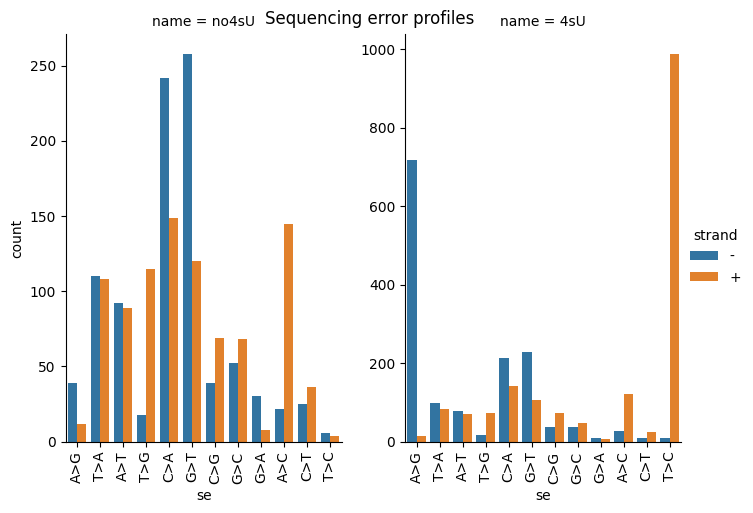

In [25]:
g = sns.catplot(seq_err_profile, kind="bar", x="se", y="count", hue="strand", col="name", aspect=0.7, sharey=False)
_ = g.set_xticklabels(rotation=90)
_ = plt.suptitle("Sequencing error profiles")

Finally, we convert the collected data from the transcriptome object to a pandas dataframe and plot the FTC values per gene showing the expected elevated FTC in the labelled sample.

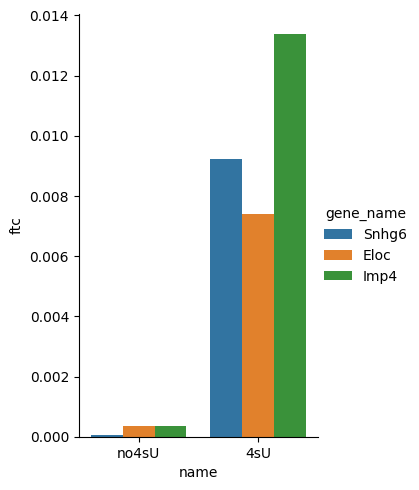

In [26]:
rows=list()
for tx in t.transcripts:
    for ds in datasets.itertuples():
        row = [ds.name, tx.parent.gene_name, tx.feature_id]
        row += [t.anno[tx][ds.name][f] for f in ('pair_count','n_seqerr','ntt','ntc')]
        rows.append(row)
dat = pd.DataFrame.from_records(rows, columns=['name', 'gene_name', 'tid', 'pair_count','n_seqerr','ntt','ntc'] )
dat['ftc'] = dat['ntc'].divide(dat['ntt']).replace(np.inf, 0)
dat['se_rate'] = dat['n_seqerr'].divide(dat['pair_count']).replace(np.inf, 0)
dat
g = sns.catplot(dat, kind="bar", x="name", y="ftc", hue="gene_name", aspect=0.7, sharey=False)

Once you have derived those counts from your paired-end dataset, you can proceed wrt. half-life estimation as described above.

# Mixture binomial model

In [30]:
#%pip install pymc  
import pymc as pm
print(f"PyMC version {pm.__version__}")

5.19.1


In [ ]:
def fit_midex_binom_model(df_lab, pmin, pmax, n):
    with pm.Model() as model:
        
        prob=[pmin, pmax] # prob
        mix_prop = pm.Dirichlet("mix_prop", a=np.ones(2))  # 2 mixture weights  
        
        # define priors
        prio_psi = pm.Uniform('psi', lower=0.00001, upper=1.0)
        
        # define likelihood (=observed stochastic)!
        components = [pm.ZeroInflatedBinomial.dist(n=n, p=p, psi=prio_psi) for p in prob]
        y = pm.Mixture('like', w=mix_prob, comp_dists=components, observed=zib_data)
        # use auto-detected sampler (here: NUTS) - its usually the best option!
        trace = pm.sample(return_inferencedata=True, progressbar=True)
        
        # extract results
        w1,w2=np.mean(trace.posterior['w'],axis=(0,1)) # w values
        psi=np.mean(1-trace.posterior['psi'])
        return w1,w2,psi,trace




with pm.Model() as model:
    

    binom_err = pm.Binomial.dist(n=N1, p=psi1)
    binom_lab = pm.Binomial.dist(n=N2, p=psi2)

    # As we just need the logp, rather than add a RV to the model, we need to call `.dist()`
    # These two forms are equivalent, but the second benefits from vectorization
    components = [
        pm.Poisson.dist(mu=binom_err),
        pm.Poisson.dist(mu=binom_err),
    ]
    # `shape=(2,)` indicates 2 mixture components
    components = pm.Poisson.dist(mu=pm.math.stack([lam1, lam2]), shape=(2,))

    like = pm.Mixture("like", w=mix_prop, 
                      comp_dists=components, observed=data)
    
    
mixmod = pm.Mixture('mixmodel', w=w, comp_dists=[dist1, dist2], observed=data)


In [ ]:
def fit_mixture_binom(zib_data, pmax, n):
    with pm.Model() as model:
        
        prob=[pmax/2, pmax] # prob
        w = pm.Dirichlet('w', a=np.array([1, 1]))  # 2 mixture weights        
        # define priors
        prio_psi = pm.Uniform('psi', lower=0.00001, upper=1.0)
        # define likelihood (=observed stochastic)!
        components = [pm.ZeroInflatedBinomial.dist(n=n, p=p, psi=prio_psi) for p in prob]
        y = pm.Mixture('like', w=w, comp_dists=components, observed=zib_data)
        # use auto-detected sampler (here: NUTS) - its usually the best option!
        trace = pm.sample(return_inferencedata=True, progressbar=True)
        
        # extract results
        w1,w2=np.mean(trace.posterior['w'],axis=(0,1)) # w values
        psi=np.mean(1-trace.posterior['psi'])
        return w1,w2,psi,trace

# fit mixture model

## Summary

This concludes our simplified SLAM-seq data analysis with *rnalib*. 
This tutorial demonstrated:

* how to annotate the T-to-C conversions in an alignment of SLAM-seq reads using *rnalib*'s `tag_tc()` method
* how to count those reads per transcript using a custom function passed to `transcriptome.annotate()`
* how to alternatively filter an annotated alignment with `filter_tc()` and use `featureCounts()` to count reads
* how to fit the counts to a simple exponential decay function with scipy/numpy
* how to QC the whole process
* how to deal with paired-end data
* how to etxract strand-specific sequencing error profiles from overlapping mate regions in a PE dataset
